In [36]:
from os import listdir
from os.path import isfile, join
import random
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf


Learning_Rate=1e-5
width=height=80 # image width and height
batchSize=1024
epochs = 60
trainPercentage = 0.80
testPercentage = 0.15
valPercentage = 0.05 

In [ ]:
torch.cuda.is_available()

In [ ]:
path = 'GeneratedImages'
files = [f for f in listdir(path) if isfile(join(path, f))]

#randomise the order of the files list
random.shuffle(files)

In [ ]:
def LoadRandomImg():
    path = 'GeneratedImages/' + files[random.randrange(0,len(files))]
    image = Image.open(path)
    
    s = path.split('_')[2]
    angle = s[0:-7]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [ ]:
def LoadImg(name):
    path = 'GeneratedImages/' + name
    image = Image.open(path)
    
    s = path.split('_')[1]
    angle = s[0:-7]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [29]:
trainFiles, valFiles, testFiles = np.split(files, [int(len(files)*trainPercentage), int(len(files)*trainPercentage) + int(len(files)*(testPercentage))])
trainFiles = np.ndarray.tolist(trainFiles)
trainFilesNotModified = trainFiles.copy()
valFiles = np.ndarray.tolist(valFiles)
testFiles = np.ndarray.tolist(testFiles)

totalBatches = math.ceil(len(trainFiles)/batchSize)

allBatches = []

for i in range(0,totalBatches):
    batch = []
    for i in range(0,batchSize):
        try:
            fileName = trainFiles[0]
            trainFiles.remove(fileName)
        except:
            fileName = files[random.randrange(0,len(files))]
        batch.append(LoadImg(fileName))
    
    allBatches.append(batch)

trainFiles = trainFilesNotModified

In [ ]:
def LoadBatch(i):
    images = torch.zeros([batchSize,3,height,width])
    angles = torch.zeros([batchSize])
    for j in range(0,batchSize):
        images[j] = allBatches[i][j][0]
        angles[j] = allBatches[i][j][1]
    return images,angles

In [33]:
def runTestOrValSet(set, modelPath, partialSet = True, partialSetPer = 0.2):
    
    if set == 'test':
        files = testFiles
    elif(set == 'val'):
        files = valFiles
    elif(set == 'train'):
        files = trainFiles
    
    if partialSet:
        random.shuffle(files)
        length = len(files)
        files = files[0:int(length*partialSetPer)]

    error = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    Net = torchvision.models.resnet50(pretrained=True)
    Net.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
    Net = Net.to(device)

    #modelPath = '19.torch'
    Net.load_state_dict(torch.load(modelPath))

    for file in files:
        image, trueAngle = LoadImg(file)

        Img = torch.autograd.Variable(image, requires_grad=False).to(device).unsqueeze(0)

        with torch.no_grad():
            Prd = Net(Img)  # Run net

        predAngle = Prd.data.cpu().numpy()

        error.append((trueAngle - predAngle)**2)

    mse = (1/len(testFiles))*(sum(error))

    print(set + " MSE: ", str(mse[0][0]))
    return mse[0][0]

MSE:  2175.2234


2175.2234

In [31]:
len(trainFiles)

193552

In [34]:
#--------------Load and set net and optimizer-------------------------------------

# Set device GPU or CPU where the training will take place
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

#load net
Net = torchvision.models.resnet50(pretrained=True)

# Change final layer to predict one value
Net.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True) 

Net = Net.to(device)

# Create adam optimizer
optimizer = torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) 



#----------------Train------------------------------------------------------------

# Save average loss for display
AverageLoss=np.zeros([50]) 

currentBatch = 0
max = len(allBatches)*epochs

mseAtEpochForVal = []
mseAtEpochForTrain = []
epochArr = []

# Training loop
for epoch in range(0,epochs):
    for batch in range(0,len(allBatches)-1):
        #print("Runing Batch: " + str(batch) + " on Epoch: " + str(epoch))
        
        # Load taining batch
        images,angle = LoadBatch(batch)
        
        # Load image
        images=torch.autograd.Variable(images,requires_grad=False).to(device) 
        
        # Load Ground truth fill level
        angle = torch.autograd.Variable(angle, requires_grad=False).to(device) 
        
        # make prediction
        predLevel=Net(images)
        Net.zero_grad()
        Loss=torch.abs(predLevel-angle).mean()
        
        # Backpropogate loss
        Loss.backward() 
        
        # Apply gradient descent change to weight
        optimizer.step() 

    # Save loss average
    AverageLoss[epoch%50]=Loss.data.cpu().numpy() 
    
    # Loss
    print(epoch,") Loss=",Loss.data.cpu().numpy(),'AverageLoss',AverageLoss.mean())       

    #Save model weight
    modelPath = str(epoch) + ".torch"
    print("Saving Model" + modelPath) 
    torch.save(Net.state_dict(),   modelPath)    

    #val set MSE
    mseAtEpochForVal.append(runTestOrValSet('val',modelPath))
    mseAtEpochForTrain.append(runTestOrValSet('train',modelPath,partialSetPer = 0.05))
    epochArr.append(epoch)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 ) Loss= 46.204887 AverageLoss 0.9240977478027343
Saving Model0.torch
MSE:  1640.8268
MSE:  2166.736
1 ) Loss= 46.202152 AverageLoss 1.8481407928466798
Saving Model1.torch
MSE:  1638.7549
MSE:  2160.893
2 ) Loss= 46.19956 AverageLoss 2.7721319580078125
Saving Model2.torch
MSE:  1643.8856
MSE:  2145.5554
3 ) Loss= 46.196507 AverageLoss 3.6960620880126953
Saving Model3.torch
MSE:  1641.568


KeyboardInterrupt: 

In [45]:
epochArr

[0, 1, 2, 4]

In [42]:
mseAtEpochForVal

[1640.8268, 1638.7549, 1643.8856, 1641.568]

In [48]:
mseAtEpochForTrain

[2166.736, 2160.893, 2145.5554, 2145.7894]

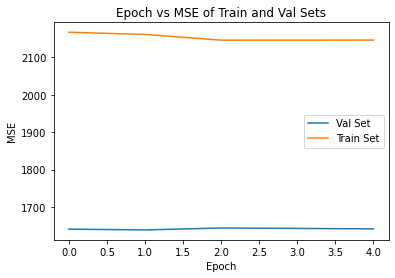

In [51]:
plt.plot(epochArr, mseAtEpochForVal, label='Val Set')
plt.plot(epochArr, mseAtEpochForTrain, label='Train Set')

plt.title('Epoch vs MSE of Train and Val Sets')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()